# Plots of AMS annual meeting Jan 2025

1. OLR & convective organization plot
2. mhist rice vs icnc
3. mhist rice vs icnc + bcu and nuc mean
4. vertical profiles
5. cross section snapshots
6. IWP vs height
   


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker
import dask
from matplotlib.gridspec import GridSpec
from scipy import stats
import util

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

plt.rcParams.update({"font.size": 18})  # all to 18 if not specified other

cb_colors = ['#377eb8', '#ff7f00', '#4daf4a',
             '#f781bf', '#a65628', '#984ea3',
             '#999999', '#e41a1c', '#dede00']
do_var=False
add_iwc_contours=True
rain_factor = 3600*1000  # mm/day

In [2]:
run_dir = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"
# run_dir = "/glade/work/sturbeville/DPSCREAM_simulations/all_run_files/"
# run = "scream_dp_RCE_SMALL_3km_lpfrz_ac.eam.h0.2000-01-01-00000.nc"
run = "dpscream_rce_large_3km_b_lpls300k_wbranch"
# file = run_dir+f"{run}/run/{run}.eam.h0.2000-02-20-10800.nc"
# file = run_dir+f"{run}/run/{run}.eam.h0.2000-01-01-00000.nc"
file = run_dir+f"{run}/run/{run}_h0_last5days.nc"
split_str = "_h0" # ".eam.h0"
# file = run_dir + run
chunks = {'time':20,'ncol':-1,'lev':-1}
qsmall=1e-8
print(file)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_b_lpls300k_wbranch/run/dpscream_rce_large_3km_b_lpls300k_wbranch_h0_last5days.nc


In [3]:
# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt(x):
    s = f"{x:.1e}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


## OLR movie

In [ ]:
ds = xr.open_dataset(file.replace("h0","h1"), chunks=chunks)[['FLUT','time','crm_grid_x', 'crm_grid_y', 'TMQ']]
ds.TMQ

In [ ]:
ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24) # for branch
print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
olr = ds.FLUT
pw = ds.TMQ
pw_anom = pw - pw.mean(dim=['ncol'])
pw_var = pw_anom.var(dim=['ncol']).values
x = ds.crm_grid_x/1000
y = ds.crm_grid_y/1000
days = np.linspace(0,ndays,len(ds.time))
print(x.shape, olr.shape, days.shape)
del ds, pw, pw_anom

In [ ]:
cmapr="cividis_r"

# do it only 60 at a time to not go over the memory limit
for t in range(47*4,48*4+1,1):  # range(len(olr.time)-2):
    print(t, olr[t].time.values)
    fig = plt.figure(figsize=plt.figaspect(0.4), layout='constrained')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[100,4])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    cax = fig.add_subplot(gs[0,1])
    im_olr = ax0.tripcolor(y[t,:], x[t,:], olr[t,:].T,
                           vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
    ax0.set(xlabel="km",ylabel="km",title="OLR (W/m$^2$)",
            xlim=[0,5120], ylim=[0,320])
    plt.colorbar(im_olr, label="W/m$^2$", cax=cax)
    ax1.plot(days[:t], pw_var[:t], 'k')
    ax1.set(xlim=[0,50],xlabel='days',
            ylim=[0,230],ylabel='PW var')
    savename=f"../plots/ams25/olr_pwvar_{run}_{days[t]:02.02f}.png"
    plt.savefig(savename)
    print("saved as "+savename)
    plt.show()

## vertical profiles

- temperature, T; ice water content, IWC; NUMICE; Q; CLDICE; CLDLIQ; QRL; QRS; W_SUB; W_SEC; 

In [ ]:
# xr.open_dataset(file).IWC.units

In [ ]:
var_name="NUMICE"
ylim=[0,20]

In [ ]:
file = run_dir+f"{run}/run/{run}_h0_last5days.nc"
zfile = run_dir+f"{run}/run/{run}_Z3_mean.nc"
var = xr.open_dataset(file)[var_name]
var_savename=var.name
var_longname=var.long_name
var_units=var.units
print("RUN:", var_longname)
var = var.mean(dim=['ncol','time'])
z = xr.open_dataset(zfile).Z3.isel(time=0).isel(x=0).isel(y=0)
z = z/1000

var4 = xr.open_dataset(file.replace("300","304"))[var_name].mean(dim=['ncol','time'])
z4 = xr.open_dataset(zfile.replace("300","304")).Z3.isel(time=0).isel(x=0).isel(y=0)
z4 = z4/1000

fig, ax1 = plt.subplots(1,1,figsize=(3,5))
ax1.plot(var, z, color=cb_colors[3], label=run.split("_")[-1])
ax1.plot(var4, z4, color=cb_colors[3], linestyle="dashed", 
         label=run.replace("300","304").split("_")[-1])
ax1.grid()
ax1.set(
        ylim=ylim,
        # xlim=[180,220],
        xlabel=f"{var_longname} ({var_units})",
        ylabel="Height (km)")
ax1.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=16)
plt.savefig(f"../plots/large/{run}_{var_savename.lower()}_profile_last5days.pdf")
print('saved as',run, var_savename)
plt.show()

## microphys joint histogram

Following Martina Kramer and Blaz Gasparini

$ R_{ice}$ vs. ICNC

In [5]:
# var_names=["T","CLDICE","NUMICE","Q","NUC","BCU","IWC"]  # "TGCLDIWP"
var_names=["T","CLDICE","NUMICE","Q"]


In [6]:
# file = run_dir+f"{run}/run/{run}_h0_last5days.nc"
print(file)
# ds = xr.open_dataset(file, chunks=chunks)[var_names].isel(time=slice(-20,-1)).isel(ncol=slice(0,20000))
ds = xr.open_dataset(file, chunks=chunks)[var_names].isel(time=slice(8*4,8*10))#.isel(ncol=slice(0,20000))
print(ds.time[0].values, ds.time[-1].values)
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
ds.Q

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_b_lpls300k_wbranch/run/dpscream_rce_large_3km_b_lpls300k_wbranch_h0_last5days.nc
2000-03-06 00:00:00 2000-03-07 00:00:00
getting t<-40 and cldice>qsmall...


<xarray.DataArray 'Q' (time: 9, lev: 128, ncol: 147456)> Size: 679MB
dask.array<where, shape=(9, 128, 147456), dtype=float32, chunksize=(8, 128, 147456), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 72B 2000-03-06 00:00:00 ... 2000-03-07 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Specific humidity
    units:         kg/kg
    mdims:         1
    mixing_ratio:  wet
    cell_methods:  time: point

In [ ]:
rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
rice

In [ ]:
icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
icnc = icnc
icnc

In [ ]:
rice_flat = rice.values.flatten()

In [ ]:
icnc_flat = icnc.values.flatten()

In [ ]:
if do_var:
    tracer_name = "RHICE"  # "T", "NUC", "BCU", "IWC", "W_NUC", "NI_NUC"
    print(tracer_name)
    if tracer_name=="NUC" or tracer_name=="BCU":
        nuc = xr.open_dataset(file.split(split_str)[0]+"_"+tracer_name+"_hrs.nc",
                              chunks=chunks)[tracer_name].isel(time=slice(-20,-1)).isel(ncol=slice(0,20000))
        var_flat = nuc.where(ds[tracer_name]>0)
    elif tracer_name=="RHICE":
        var_flat = util.calc_rhice(ds)
    else:
        var_flat = ds[tracer_name]
    print(var_flat)

In [ ]:
if do_var:
    var_flat = var_flat.values.flatten()
    var_flat

In [ ]:
rice_flat.shape, icnc_flat.shape  # , var_flat.shape

In [ ]:
# rice_plot = np.where((var_flat>=7)&(var_flat<8), rice_flat, np.nan)
# icnc_plot = np.where((var_flat>=7)&(var_flat<8), icnc_flat, np.nan)
# do_var=False

In [7]:
n = np.sum(~np.isnan(rice_flat))
n

NameError: name 'rice_flat' is not defined

In [ ]:
rice_bins=np.linspace(0,100,100)
icnc_bins=np.logspace(-5,2,70)

In [ ]:
do_var  # , tracer_name

In [ ]:
stat='median'
if do_var:
    hist, _, _, _ = stats.binned_statistic_2d(rice_flat,
                                              icnc_flat,
                                              (var_flat),
                                              statistic=stat,
                                              bins=[rice_bins, icnc_bins])
    # hist = np.where(hist>0,hist,np.nan)
else:
    hist, _, _, _ = stats.binned_statistic_2d(rice_flat,
                                              icnc_flat,
                                              None,
                                              statistic='count',
                                              bins=[rice_bins, icnc_bins])
    stat = 'count'
    # hist = np.where(hist>0,hist,np.nan)
    # hist = hist/n
    # print("normalized...")
xbins = (rice_bins[1:]+rice_bins[:-1])/2
ybins = (icnc_bins[1:]+icnc_bins[:-1])/2

In [ ]:
da = xr.DataArray(hist, dims=["rice_bins","icnc_bins"],
                  coords={"rice_bins":xbins, "icnc_bins":ybins}, 
                  attrs={'normalize by':str(n), 
                         'name':'count of points with T<-40degC and qi>1e-8 for days 5-10 of lp_300k sim'})
ds = xr.Dataset({'hist2d':da}, attrs=da.attrs)
ds

ds.to_netcdf("mhist_count_lp300k_small_days5-10.nc")

In [ ]:
ds

In [ ]:
xbins.shape, ybins.shape, hist.shape

In [ ]:
# iwc_hist = xr.open_dataset("IWC_jhist_rice_icnc_bins.nc").IWC_jhist
# iwc_hist

In [ ]:
print("plotting... ")
fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True)

if do_var:
    print("var")
    cf = ax.contourf(xbins, ybins, hist.T,
                     # (hist*100).T,
                     cmap="cividis",
                     shading='auto',
                     # levels=np.arange(180,220.1,5),
                     # levels=np.arange(0,24.1,2),
                     levels=np.arange(80,120.1,10),
                     # vmin = 0, vmax=24 #0.02, 0.3 std
                     # vmin=170,vmax=220
                     # vmin=1e-7, vmax=10,
                     # norm=mcolors.LogNorm(vmin=1e-7, vmax=0.1),
                     extend="max"
                     )
    plt.colorbar(cf, ax=ax, label=f"{tracer_name} (hr)", location="bottom", shrink=0.8, extend='max')
else:
    print("count")
    cf = ax.pcolormesh(xbins, ybins,
                       (hist*100).T,
                       cmap="magma_r",
                       shading='auto',
                       # levels=[0,1,2,4,8,16,32,48]
                       vmin=0, vmax=0.6,  # 0.02, 0.3 std
                       # levels=np.arange(0,0.6,0.1),
                       )
    plt.colorbar(cf, ax=ax, label="pdf", location="bottom", shrink=0.8, extend='max')
# iwc_hist = xr.open_dataset("IWC_jhist_rice_icnc_bins.nc").IWC_jhist
# ct = ax.contour(xbins, ybins, (iwc_hist).T, colors='k', levels=np.logspace(-6,-1,6))
# ax.text(101, 2e-1, "1e-1 g/m$^3$", fontsize=10)
# ax.text(101, 2e-2, "1e-2 g/m$^3$", fontsize=10)
# ax.text(101, 2e-3, "1e-3 g/m$^3$", fontsize=10)
# ax.text(101, 2e-4, "1e-4 g/m$^3$", fontsize=10)
# ax.text(82,  6e-5, "1e-5 g/m$^3$", fontsize=10)
# ax.text(40,  6e-5, "1e-6 g/m$^3$", fontsize=10)
if not do_var:
    ax.annotate(n, xy=(0.02,0.95), xycoords="axes fraction")
ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
if do_var:
    plt.savefig(f"../plots/ams25/micro_hist_run_{run}_{stat}_{tracer_name}.png")
else:
    plt.savefig(f"../plots/ams25/micro_hist_run_{run}_count.png")
plt.show()

In [ ]:
rice_bins.shape, icnc_bins.shape, hist.shape

In [ ]:
# ds = xr.Dataset({"IWC_jhist":xr.DataArray(hist*100, coords={'RICE_bins':xbins,'ICNC_bins':ybins})}, attrs={'long_name':'IWC jhist RICE vs ICNC for contour plotting'})
# ds

## W_NUC histogram for certain values of ICNC and RICE

In [7]:
plt_ci_type = "insitu" # choose from 'insitu' or 'detrained' or 'recent'
tracer_name = "W_NUC" # W_NUC or height

In [8]:
var_names=["T","CLDICE","NUMICE","Q","Z3"]
ds = xr.open_dataset(file, chunks=chunks)[var_names]
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
ds.Q

getting t<-40 and cldice>qsmall...


<xarray.DataArray 'Q' (time: 41, lev: 128, ncol: 147456)> Size: 3GB
dask.array<where, shape=(41, 128, 147456), dtype=float32, chunksize=(20, 128, 147456), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 328B 2000-03-02 00:00:00 ... 2000-03-07 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Specific humidity
    units:         kg/kg
    mdims:         1
    mixing_ratio:  wet
    cell_methods:  time: point

In [9]:
rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
rice

<xarray.DataArray (time: 41, lev: 128, ncol: 147456)> Size: 3GB
dask.array<mul, shape=(41, 128, 147456), dtype=float32, chunksize=(20, 128, 147456), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 328B 2000-03-02 00:00:00 ... 2000-03-07 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol

In [ ]:
icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
icnc = icnc/1e6
icnc

In [ ]:
# var_da = xr.open_dataset(file.split(".eam.h0")[0]+"_"+tracer_name+"_hrs.nc",
#                          chunks=chunks)[tracer_name]
# nuc_da = xr.open_dataset(file.split(".eam.h0")[0]+"_NUC_hrs.nc",
#                               chunks=chunks)["NUC"]
var_da = ds.Z3/1000 # km
var_da

In [ ]:
if plt_ci_type=="insitu":
    # in-situ formed cirrus
    rice_low, rice_hgh = 0, 7
    icnc_low, icnc_hgh = 1e-2, 1
    print("insitu")
elif plt_ci_type=="detrained":
    # recently detrained cirrus
    rice_low, rice_hgh = 10, 30
    icnc_low, icnc_hgh = 1e-1, 1
    print("detrained")
elif plt_ci_type=="recent":
    # VERY recently detrained cirrus
    rice_low, rice_hgh = 30, 50
    icnc_low, icnc_hgh = 7e-2, 3e1
    print("detrained")
else:
    raise Exception("Need to set one of plt_ci_type to insitu or detrained")
var_da = var_da.where((rice>=rice_low)&(rice>rice_hgh)&(icnc>=icnc_low)&(icnc<icnc_hgh))
var_da

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3), constrained_layout=True)
var_da.plot.hist(
                 # bins=np.linspace(0,5,40),
                 bins=np.linspace(12,18,36),
                 ax=ax,
                 # bins=np.logspace(-2.5,1.4,20),
                 # xscale="log",
)
ax.set(xlabel=var_name, ylabel="count")
ax.set(title=f"{plt_ci_type}\n{icnc_low} < ICNC < {icnc_hgh}; {rice_low} < RICE < {rice_hgh}")
plt.savefig(f"../plots/ams25/{var_name}_{plt_ci_type}_histogram_{run}.png")
plt.show()

## cross section

In [4]:
t=-13
print(file)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_b_lpls300k_wbranch/run/dpscream_rce_large_3km_b_lpls300k_wbranch.eam.h0.2000-02-20-10800.nc


In [5]:
ds = xr.open_dataset(file).isel(time=t)[['CLDICE','QRS', 'QRL', 'TMQ',
                                         'crm_grid_x','crm_grid_y', 'OMEGA',
                                         'T']]
x = ds.crm_grid_x
y = ds.crm_grid_y
iwc = ds.CLDICE
temp = ds['T']
time = ds.time
print(x.shape, y.shape, time.values)

(147456,) (147456,) 2000-02-23 12:00:00


In [6]:
# ds['T'].mean(dim=['ncol']).plot(y='lev')

In [7]:
w = util.omega2w(ds.OMEGA, ds.lev*100, temp)
# w = ds.OMEGA

In [8]:
lw_heating = ds.QRL
sw_heating = ds.QRS
pw = ds[['TMQ','crm_grid_y']]
del ds

In [9]:
lw_heating

<xarray.DataArray 'QRL' (lev: 128, ncol: 147456)> Size: 75MB
[18874368 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
    time     object 8B 2000-02-23 12:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:              1
    Sampling_Sequence:  rad_lwsw
    units:              K/s
    long_name:          Longwave heating rate
    cell_methods:       time: point

In [10]:
# iwc.mean(dim=['ncol'], skipna=True).plot(y='lev', ylim=[1000,50], yscale='log')

In [11]:
cross_mask = np.where(x < 10, 1, 0)
print(cross_mask.shape)
x0 = x.where(cross_mask)
y0 = y.where(cross_mask)
print(x0.shape, y0.shape)
ncross = np.nansum(cross_mask)
print(ncross)

(147456,)
(147456,) (147456,)
1536


In [12]:
nuc = (
    xr.open_dataset(run_dir + f"{run}/run/{run}_NUC_hrs.nc").sel(time=time, method="nearest").NUC
)
bcu = (
    xr.open_dataset(run_dir + f"{run}/run/{run}_BCU_hrs.nc").sel(time=time, method="nearest").BCU
)
z = (
    xr.open_dataset(run_dir + f"{run}/run/{run}_Z3_mean.nc")
    # xr.open_dataset(run_dir + run + "_Zmean_last5days.nc")
    # .sel(time=time, method="nearest")
    .Z3[0, :, 0, 0]/1000
)

In [13]:
nuc.shape, bcu.shape, z.shape

((128, 147456), (128, 147456), (128,))

In [14]:
pw_plot = pw['TMQ'].groupby(pw.crm_grid_y).mean()
pw_plot

<xarray.DataArray 'TMQ' (crm_grid_y: 1536)> Size: 6kB
array([17.87144 , 17.878294, 17.895208, ..., 17.878197, 17.87171 ,
       17.868406], dtype=float32)
Coordinates:
    time        object 8B 2000-02-23 12:00:00
  * crm_grid_y  (crm_grid_y) float32 6kB 0.0 2.764e+03 ... 5.113e+06 5.117e+06
Attributes:
    units:          kg/m2
    long_name:      Total (vertically integrated) precipitable water
    standard_name:  atmosphere_mass_content_of_water_vapor
    cell_methods:   time: point

In [15]:
iwc_plot = iwc.where(cross_mask[np.newaxis, :])
nuc_plot = nuc.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
bcu_plot = bcu.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
qrl_plot = lw_heating.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
qrs_plot = sw_heating.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
w_plot = w.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))

In [16]:
# iwc_plot.mean().values

2000-02-23T12h


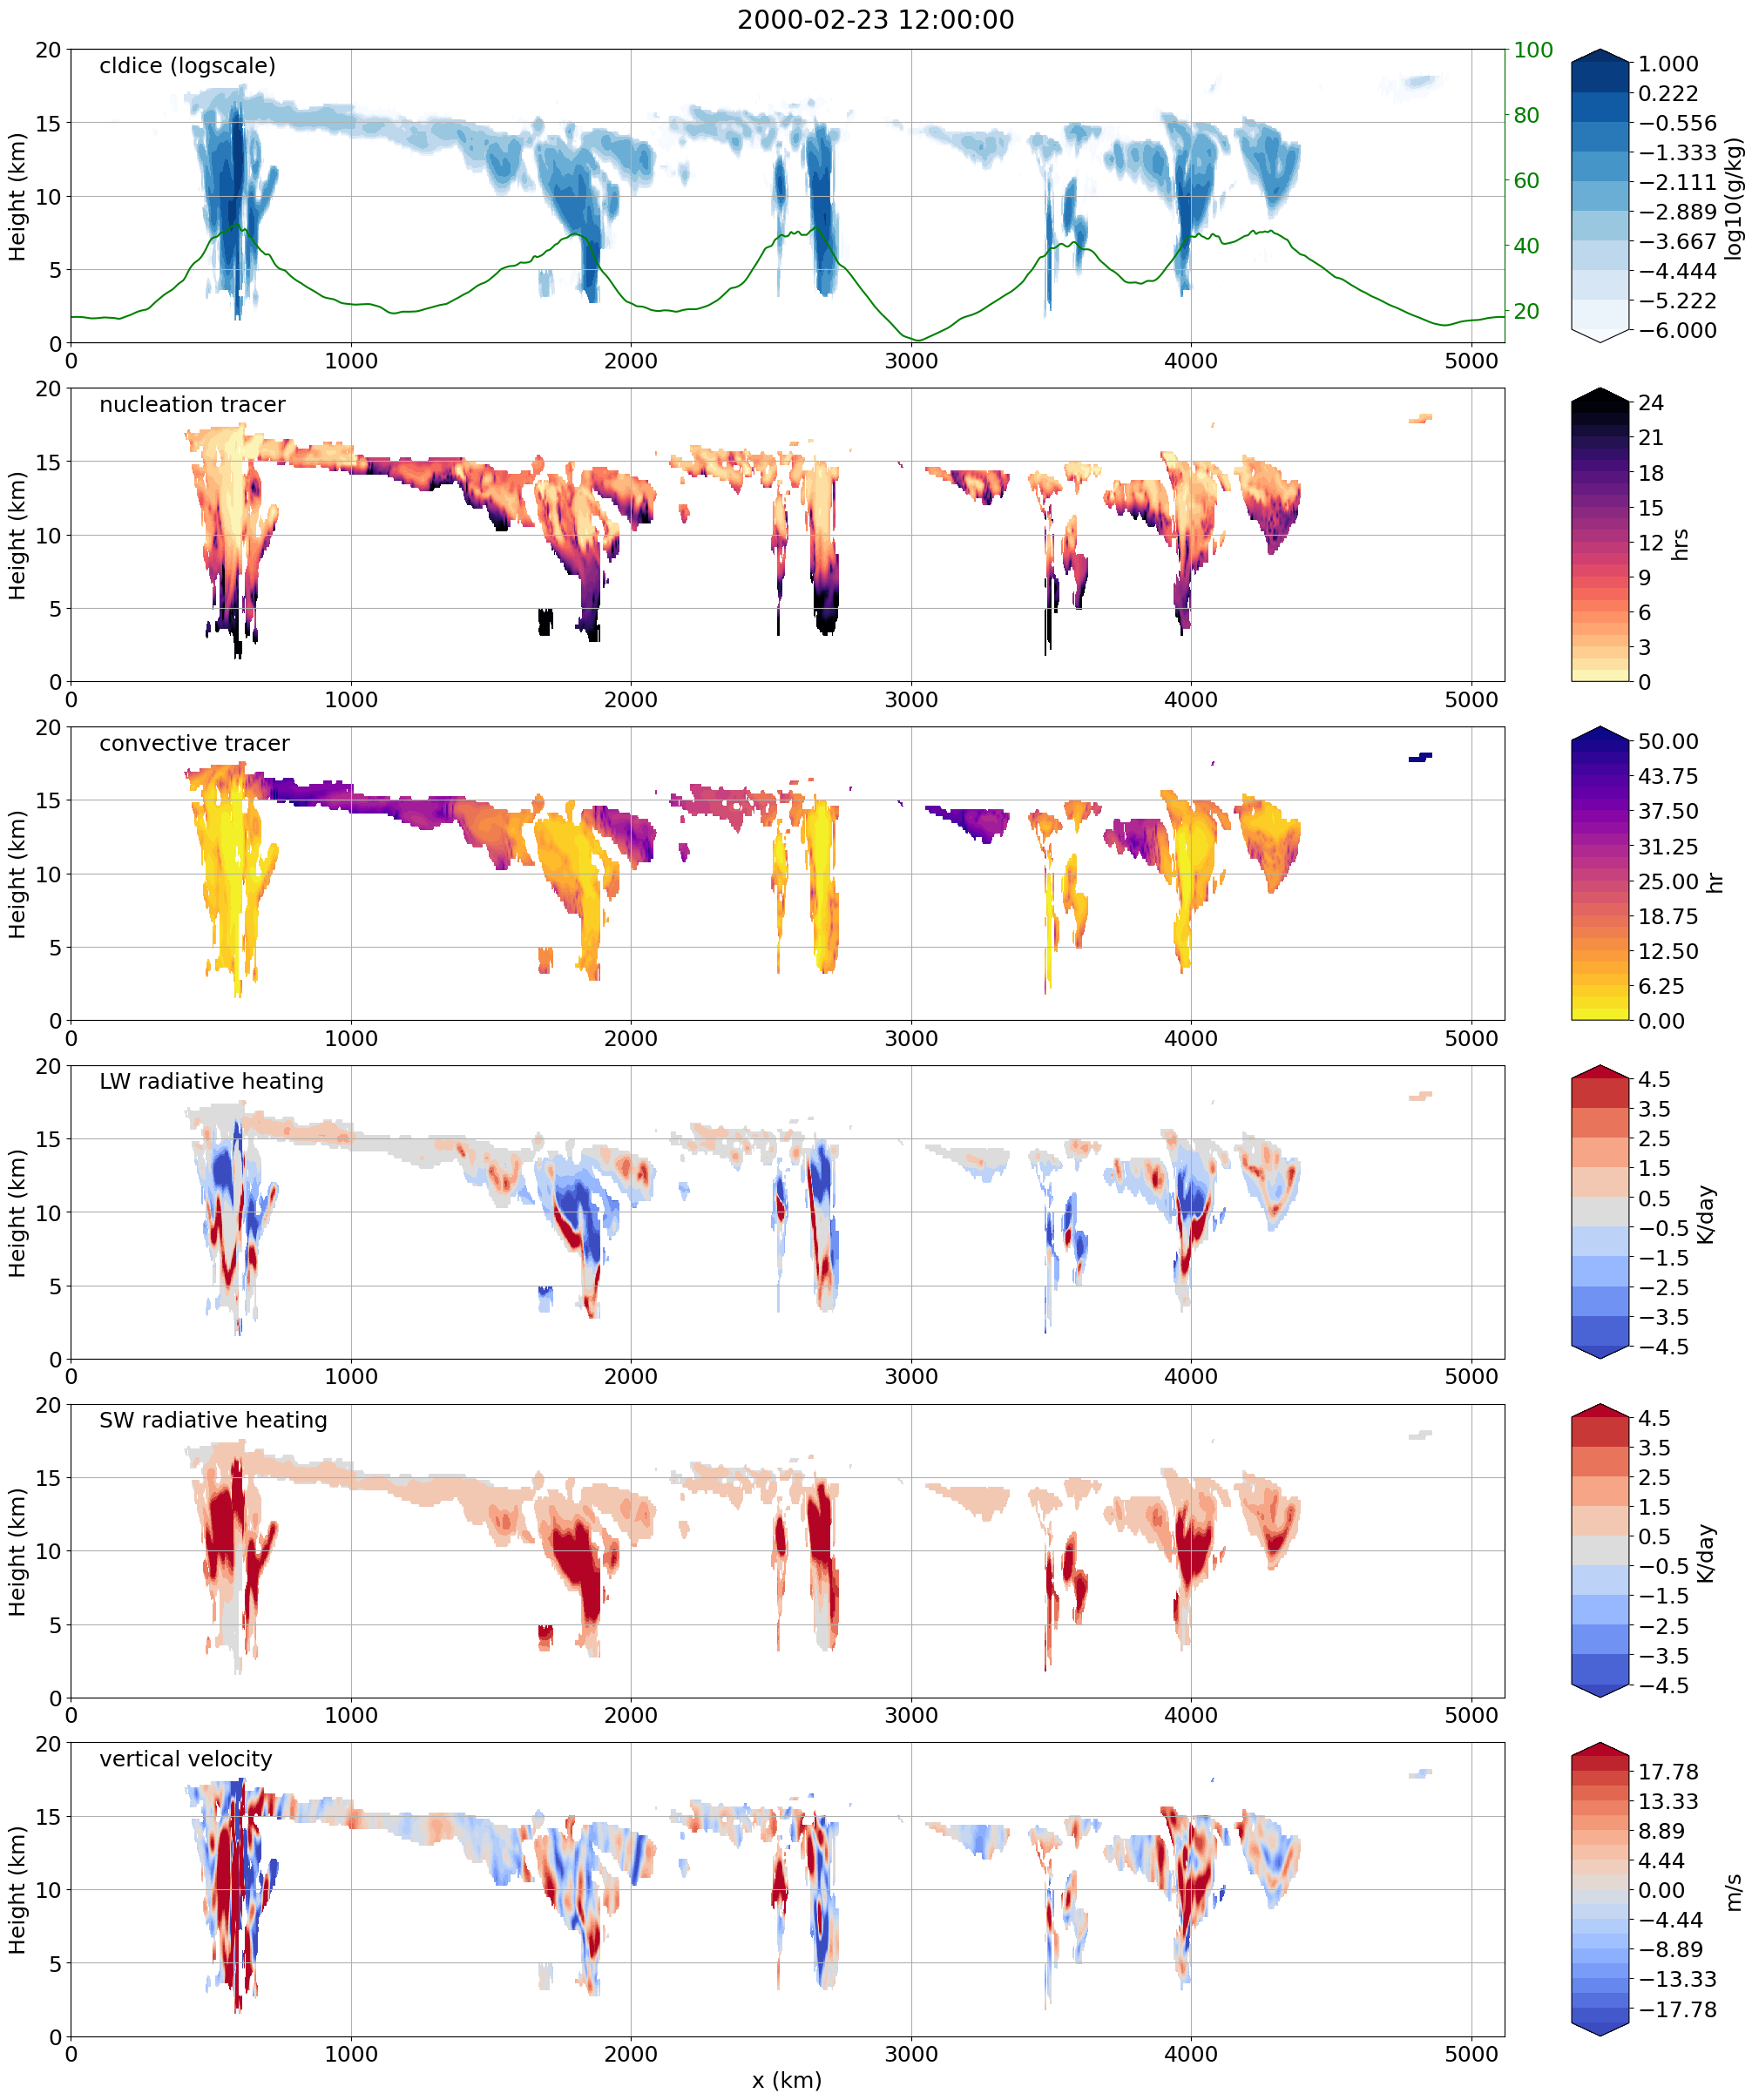

In [18]:
fig = plt.figure(figsize=(20, 24), layout="constrained")
gs = GridSpec(6, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
cf = ax0.contourf(
    y / 1000,
    z,
    np.log10(iwc_plot * 1000),
    levels=np.linspace(-6, 1, 10),
    # vmin=-6, vmax=1,
    extend="both",
    cmap="Blues",
)
plt.colorbar(cf, cax=cax0, label="log10(g/kg)")
ax0t = ax0.twinx()
ax0t.plot(pw_plot.crm_grid_y/1000, pw_plot.values, 'green')
ax0t.set(ylim=[10,100])
ax0t.spines['right'].set_color('green')
ax0t.tick_params(axis='y', colors='green')
ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
cf = ax1.contourf(
    y / 1000,
    z,
    nuc_plot,
    levels=np.linspace(0, 24, 25),
    # vmin=0, vmax=50,
    extend="max",
    cmap="magma_r",
)
plt.colorbar(cf, cax=cax1, label="hrs")
ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
cf = ax2.contourf(
    y / 1000,
    z,
    bcu_plot,
    levels=np.linspace(0, 50, 25),
    # vmin=0, vmax=50,
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax2, label="hr")
ax3 = fig.add_subplot(gs[3, 0])
cax3 = fig.add_subplot(gs[3, 1])
cf = ax3.contourf(
    y / 1000,
    z,
    qrl_plot * 3600 * 24,
    levels=np.linspace(-4.5,4.5,10),
    # vmin=-4.5, vmax=4.5,
    extend="both",
    cmap="coolwarm",
)
plt.colorbar(cf, cax=cax3, label="K/day")
ax4 = fig.add_subplot(gs[4, 0])
cax4 = fig.add_subplot(gs[4, 1])
cf = ax4.contourf(
    y / 1000,
    z,
    qrs_plot * 3600 * 24,
    levels=np.linspace(-4.5, 4.5, 10),
    # vmin=-4.5, vmax=4.5,
    extend="both",
    cmap="coolwarm",
)
plt.colorbar(cf, cax=cax4, label="K/day")
ax5 = fig.add_subplot(gs[5, 0])
cax5 = fig.add_subplot(gs[5, 1])
cf = ax5.contourf(
    y / 1000,
    z,
    w_plot*100,
    levels=np.linspace(-20, 20, 19),
    # vmin=-1, vmax=1,
    extend="both",
    cmap="coolwarm",
)
plt.colorbar(cf, cax=cax5, label="m/s")
ax0.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax1.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax2.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax3.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax4.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax5.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)", xlabel="x (km)")
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax5.grid(True)
ax0.annotate("cldice (logscale)", xy=(0.02,0.92), xycoords="axes fraction")
ax1.annotate("nucleation tracer", xy=(0.02,0.92), xycoords="axes fraction")
ax2.annotate("convective tracer", xy=(0.02,0.92), xycoords="axes fraction")
ax3.annotate("LW radiative heating", xy=(0.02,0.92), xycoords="axes fraction")
ax4.annotate("SW radiative heating", xy=(0.02,0.92), xycoords="axes fraction")
ax5.annotate("vertical velocity", xy=(0.02,0.92), xycoords="axes fraction")
fig.suptitle(str(nuc.time.values))
time_string = str(time.values).replace(" ","T").split(":")[0]+"h"
print(time_string)
plt.savefig(f"../plots/ams25/cross_section_iwc_nuc_bcu_qrl_qrs_w_{run}_{time_string}.png")
plt.show()

## IWP or $\tau_{conv}$ vs height

In [ ]:
# load the data
xvar_name = "IWP"
tbeg=-6
thres=5e-8  # kg/m3
if xvar_name=="BCU":
    bcu_ds = xr.open_dataset(file.split(".eam.h0")[0]+"_BCU_hrs.nc", chunks=chunks).BCU.isel(time=slice(tbeg,-1))
ds = xr.open_dataset(file, chunks=chunks)[['TGCLDIWP','IWC','T','OMEGA','NUMICE','Q','CLDICE']].isel(time=slice(tbeg,-1))
ds = ds.where(ds.IWC>=thres)
z = xr.open_dataset(file.split(".eam.h0")[0]+"_Z3_mean.nc").Z3[0,:,0,0]
ds

In [ ]:
# calculate variable to plot
stat="median"
cvar_name="IWC"
cvar_label="g/m3"
if cvar_name=="W":
    var_ds = util.omega2w(ds.OMEGA, ds.lev*100, ds['T'])
elif cvar_name=="NI":
    var_ds = util.calc_ni(ds.NUMICE, ds.Q, ds.lev, ds['T'])/1e6
elif cvar_name=="RICE":
    var_ds = util.calc_rice(ds.CLDICE, ds.NUMICE)
elif cvar_name=="IWC":
    var_ds = (ds.IWC)*1000
elif cvar_name=="NUC":
    var_ds = xr.open_dataset(file.split(".eam.h0")[0]+"_NUC_hrs.nc"
                             ).NUC.isel(time=slice(tbeg,-1)
                                        ).where(ds.IWC>=thres)
elif cvar_name=="BCU":
    var_ds = xr.open_dataset(file.split(".eam.h0")[0]+"_BCU_hrs.nc"
                             ).BCU.isel(time=slice(tbeg,-1)
                                        ).where(ds.IWC>=thres)
elif cvar_name=="W_NUC":
    var_ds = xr.open_dataset(file.split(".eam.h0")[0]+"_W_NUC_hrs.nc"
                             ).W_NUC.isel(time=slice(tbeg,-1)
                                          ).where(ds.IWC>=thres)
    # var_ds = util.omega2w(var_ds, var_ds.lev*100, ds['T'])
elif cvar_name=="CLD_FRAC":
    var_ds = xr.where(ds.IWC>=thres,1,0, keep_attrs=True)
var_ds

In [ ]:
print(xvar_name, cvar_name)
if xvar_name=="IWP":
    # organize into IWP percentiles
    x_da = ds.TGCLDIWP.where(ds.TGCLDIWP>0)
    x_bin_edges = np.linspace(0,1,30)
    x_bin_values = np.zeros(x_bin_edges.shape)
elif xvar_name=="BCU":
    x_da = bcu_ds
    x_bin_edges = np.linspace(0,30,25)
    x_bin_values = x_bin_edges
var_binned_by_x = np.zeros((len(x_bin_edges), len(var_ds.lev)))
print(x_bin_edges.shape, var_ds.shape, var_binned_by_x.shape)

# do the first one
print(0, x_bin_values[1])
if stat=="mean":
    var_binned_by_x[0,:] = var_ds.where(x_da<x_bin_values[1]
                                        ).mean(dim=['time','ncol'],
                                               skipna=True)
elif stat=="median":
    var_binned_by_x[0,:] = var_ds.where((x_da<x_bin_values[1])
                                        ).median(dim=['time','ncol'],
                                                 skipna=True)
# do the rest
for i in range(1,len(x_bin_edges)):
    if xvar_name=="IWP":
        x_bin_values[i] = x_da.quantile(x_bin_edges[i]).mean()
    print(i, x_bin_values[i-1], x_bin_values[i])
    if stat=="mean":
        var_binned_by_x[i,:] = var_ds.where((x_da<x_bin_values[i])&
                                            (x_da>=x_bin_values[i-1])
                                            ).mean(dim=['time','ncol'],
                                                   skipna=True)
    elif stat=="median":
        var_binned_by_x[i,:] = var_ds.where((x_da<x_bin_values[i])&
                                            (x_da>=x_bin_values[i-1])
                                            ).median(dim=['time','ncol'],
                                                     skipna=True)
    print(var_binned_by_x[i,40])

In [ ]:
# Height vs IWC percentile
fig, ax = plt.subplots(1,1, figsize=(8,5))
im = ax.contourf(x_bin_edges, z/1000, (var_binned_by_x).T,
                 cmap="ocean_r",
                 # vmin=1e-7, vmax=1,
                 # norm=mcolors.TwoSlopeNorm(0),
                 # norm=mcolors.LogNorm(vmin=2e-4,vmax=0.04),
                 # norm=mcolors.SymLogNorm(linthresh=1, linscale=0.2,
                 #                         vmin=-10.0, vmax=10.0, base=10),
                 # vmin=-5, vmax=5,
                 # vmin=0, vmax=24,
                 # shading='auto',
                 # levels=np.arange(0,120,10),
                 # locator=ticker.LogLocator(subs='all'),
                 # levels=np.arange(-5,5.1,0.5),
                 # levels=np.arange(0,24,1),
                 # levels=np.arange(0,1.01,0.1),
                 # levels=[-2,-1,-0.5,-0.25,0,0.25,0.5,1,2],
                 # levels=np.arange(-50,50,10),
                 levels=np.logspace(-4,0,9),
                 # levels=np.logspace(-4,1,5*2+1),
                 norm=mcolors.LogNorm(),
                 extend="both"
                 )
ax.contour(im, levels=[0], colors='k')
# xticklabels = [f"{i:.1e}" for i in iwp_bin_edges]
# axt = ax.twiny()
# axt.set(xticks=iwp_perc_edges[5::10],
#         xticklabels=xticklabels[5::10])
plt.colorbar(im, ax=ax, location='right',
             label=f"{cvar_name} ({cvar_label})")
ax.set(ylim=[3,20],
       yticks=np.arange(5,20,5),
       ylabel="height (km)")
if xvar_name=="IWP":
    ax.set(xlabel="IWP percs", xlim=[0.1,1])
    ax.invert_xaxis()
else:
    ax.set(xlabel="time since convection", xlim=[0,30])
ax.grid(True)
ax.set(title=f"in-cld {cvar_name} (IWC $\geq$ {thres} kg/m$^3$)")
savename=f"../plots/ams25/{xvar_name}_vs_height_{cvar_name}_{stat}_{thres}.png"
print(savename)
plt.savefig(savename, bbox_inches="tight", pad_inches=0.5, dpi=120)
plt.show()

## in-situ vs recently detrained cirrus clouds properties

In [4]:
# ds = xr.open_dataset(file, chunks=chunks)
# ds

In [5]:
plt_type="insitu"
var_name = "W_NUC"
var_units = "cm/s"
tbeg=-12
thres=5e-8  # kg/m3


bcu_ds = xr.open_dataset(file.split(split_str)[0]+"_BCU_hrs.nc", chunks=chunks).BCU.isel(time=slice(tbeg,-1))
nuc_ds = xr.open_dataset(file.split(split_str)[0]+"_NUC_hrs.nc", chunks=chunks).NUC.isel(time=slice(tbeg,-1))
wnuc_ds = xr.open_dataset(file.split(split_str)[0]+"_W_NUC_hrs.nc", chunks=chunks).W_NUC.isel(time=slice(tbeg,-1))

if var_name=="BCU":
    var_ds = xr.open_dataset(file.split(split_str)[0]+"_BCU_hrs.nc", chunks=chunks).isel(time=slice(tbeg,-1)).BCU
    ds = xr.open_dataset(file, chunks=chunks)[["IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(ds.IWC>=thres)
    bins = np.linspace(0,30,30)
elif var_name=="NUC":
    var_ds = xr.open_dataset(file.split(split_str)[0]+"_NUC_hrs.nc", chunks=chunks).isel(time=slice(tbeg,-1)).NUC
    ds = xr.open_dataset(file, chunks=chunks)[["IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(ds.IWC>=thres)
    bins = np.linspace(0,30,30)
elif var_name=="W_NUC":
    var_ds = xr.open_dataset(file.split(split_str)[0]+"_W_NUC_hrs.nc", chunks=chunks).isel(time=slice(tbeg,-1)).W_NUC
    ds = xr.open_dataset(file, chunks=chunks)[["IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(ds.IWC>=thres)*100
    bins = np.linspace(-5,20,26)
elif var_name=="IWC":
    var_ds = xr.open_dataset(file, chunks=chunks)[[var_name]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(var_ds.IWC>=thres).IWC*1000
    bins = np.logspace(-7,0,15)
# elif var_name=="IWP":
#     var_ds = xr.open_dataset(file, chunks=chunks)[["TGCLDIWP", "IWC"]].isel(time=slice(tbeg,-1))
#     var_ds = var_ds.where((var_ds.IWC>=thres).any())
elif var_name=="NI" or var_name=="ICNC":
    ds = xr.open_dataset(file, chunks=chunks)[["IWC","CLDICE","T","Q","OMEGA","NUMICE"]].isel(time=slice(tbeg,-1))
    var_ds = util.calc_ni(ds.NUMICE, ds.Q, ds.lev, ds['T'])
    bins = np.logspace(-7,1,15)
elif var_name=="RICE":
    ds = xr.open_dataset(file, chunks=chunks)[["IWC","CLDICE","T","Q","OMEGA","NUMICE"]].isel(time=slice(tbeg,-1))
    var_ds = util.calc_rice(ds.CLDICE, ds.NUMICE)
    bins = np.linspace(0,20,19)
elif var_name=="RHice":
    ds = xr.open_dataset(file, chunks=chunks)[["IWC","T","Q"]].isel(time=slice(tbeg,-1))
    var_ds = util.calc_rhice(ds)
    bins = np.linspace(95,130,30)
elif var_name=="W":
    ds = xr.open_dataset(file, chunks=chunks)[["IWC","CLDICE","T","Q","OMEGA","NUMICE"]].isel(time=slice(tbeg,-1))
    var_ds = util.omega2w(ds.OMEGA, ds.lev*100, ds['T'])*100
    bins = np.linspace(-20,20,21)
elif var_name=="WSUB" or var_name=="W_SEC":
    var_ds = xr.open_dataset(file, chunks=chunks)[[var_name,"IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(var_ds.IWC>=thres)[var_name]*100
    bins = np.linspace(-2,2,21)
elif var_name=="height":
    var_ds = xr.open_dataset(file, chunks=chunks)[["Z3","IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(var_ds.IWC>=thres).Z3/1000
    bins=np.linspace(10,20,15)
elif var_name[:2]=="QR":
    var_ds = xr.open_dataset(file, chunks=chunks)[[var_name,"IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(var_ds.IWC>=thres)[var_name]*3600*24
    bins=np.linspace(-2,2,12)
else:
    var_ds = xr.open_dataset(file, chunks=chunks)[[var_name,"IWC"]].isel(time=slice(tbeg,-1))
    var_ds = var_ds.where(var_ds.IWC>=thres)[var_name]
    bins=np.linspace(180,220,20)

if plt_type=="insitu":
    var_ds = var_ds.where((bcu_ds>24)&(nuc_ds<1))
elif plt_type=="detrained":
    var_ds = var_ds.where((bcu_ds>3)&(bcu_ds<6))
elif plt_type=="both":
    ins_ds = var_ds.where((bcu_ds>24)&(nuc_ds<bcu_ds))
    det_ds = var_ds.where((bcu_ds>24)&(nuc_ds<bcu_ds))
# var_ds = var_ds[var_name]
var_ds

<xarray.DataArray 'W_NUC' (time: 11, lev: 128, ncol: 147456)> Size: 830MB
dask.array<where, shape=(11, 128, 147456), dtype=float32, chunksize=(11, 128, 147456), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 88B 2000-03-05 15:00:00 ... 2000-03-06 21:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol

In [6]:
# np.nanmin(var_ds), np.nanmax(var_ds), np.nanmean(var_ds)

In [7]:
if plt_type=="both":
    print("both insitu and detrained")
    print(ins_ds.shape, det_ds.shape)
    n = np.prod(ins_ds.shape)
    n_ins = ins_ds.count().values
    n_det = det_ds.count().values
    print(n_ins, n_det)
    hist_ins, bins = np.histogram((ins_ds.values.flatten()),
                                  bins=bins,
                                  density=False)
    hist_det, _ = np.histogram((det_ds.values.flatten()),
                               bins=bins,
                               density=False)
    hist_ins = hist_ins/n_ins
    hist_det = hist_det/n_det
else:
    print(plt_type)
    n = var_ds.count().values
    hist, bins = np.histogram((var_ds.values.flatten()),
                              bins=bins,
                              density=False)
    hist = hist/n
    print(n)

insitu
[########################################] | 100% Completed | 6.82 sms
[########################################] | 100% Completed | 4.27 sms
90408


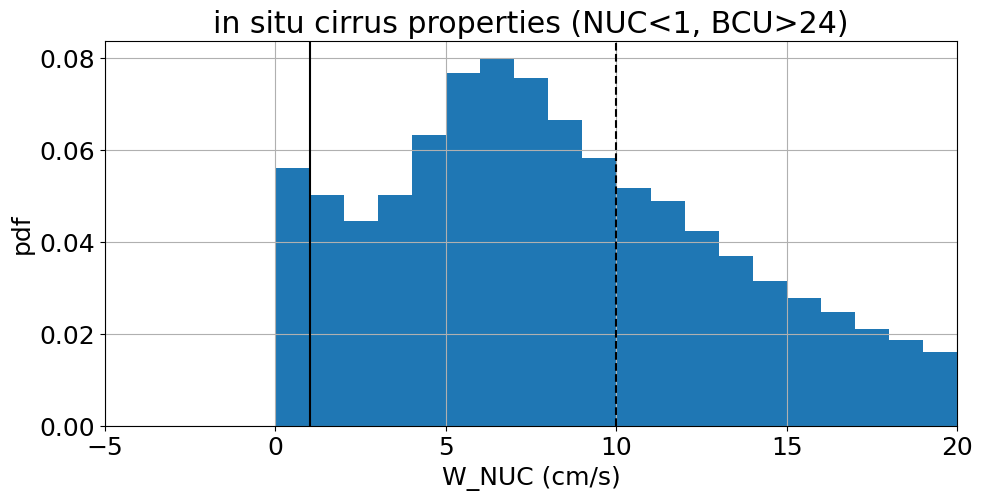

In [8]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
bin_widths = bins[1:]-bins[:-1]
bin_mids = (bins[1:]+bins[:-1])/2
if plt_type=="both":
    t=0
    ax.step(bin_mids[t:], hist_det[t:], color="mediumblue", label="fast updraft", lw=2, linestyle='-', where='mid')
    ax.step(bin_mids[t:], hist_ins[t:], color="deepskyblue", label="slow updraft", lw=2, linestyle='-', where='mid')
    ax.legend()
else:
    ax.bar(bin_mids, hist, width=bin_widths, align='center')
    # ax.plot(hist, bin_mids)
ax.set(xlabel=f"{var_name} ({var_units})", ylabel='pdf')
# ax.set(ylabel=f"{var_name} ({var_units})", xlabel='pdf')
ax.axvline(x=1, ymin=0, color='k')
ax.axvline(x=10, ymin=0, color='k', linestyle='--')
ax.set(xlim=[bins[0], bins[-1]])
# ax.set(ylim=[0,0.025])
ax.grid()
ax.set(title="in situ cirrus properties (NUC<1, BCU>24)")
# ax.annotate(f"{n_ins}\n{n_det}", (0.01,0.85), xycoords="axes fraction")
if var_name=="IWC" or var_name=="NI" or var_name=="ICNC":
    ax.set(xscale='log')
plt.savefig(f"../plots/ams25/cirrus_{plt_type}_hist_{var_name}_{run}.png", dpi=150,
            bbox_inches="tight", pad_inches=0.5, transparent=True)
plt.show()

#

## other plots


In [ ]:
# Scatter plots
ds = xr.open_dataset(file.split("_h0")[0]+".eam.h1.2000-01-01-00000.nc")
ds

In [ ]:
plt.hist2d(ds.FLUT.values.flatten(), (ds.TGCLDIWP.values.flatten()),
           bins=[np.linspace(80,310,23),np.logspace(-4,2,30)], density=False,
           cmin=1, cmax=5e5)
# plt.ylim([-4,2])
# n = np.prod(ds.FLUT.shape)
plt.yscale("log")
plt.grid()
plt.colorbar(extend="max")
plt.show()

In [ ]:
plt.hist2d(ds.TGCLDIWP.values.flatten(), (ds.OMEGA500.values.flatten()),
           bins=[np.logspace(-4,2,30),[-15,-5,-2,-1,-0.5,-0.25,0.25,1,2,10]],
           # density=True, 
           norm=mcolors.LogNorm(vmin=1,vmax=5e5),
          )
# plt.ylim([-4,2])
# n = np.prod(ds.FLUT.shape)
plt.xscale("log")
plt.grid()
plt.colorbar()
plt.show()

In [ ]:
plt.hist2d(ds.TGCLDIWP.values.flatten(), (ds.PRECL.values.flatten())*rain_factor,
           bins=[np.logspace(-4,2,30),np.logspace(-2,3)], density=False,
           norm=mcolors.LogNorm(vmin=10,vmax=5e5),
           )
# plt.ylim([-4,2])
# n = np.prod(ds.FLUT.shape)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.colorbar(extend="max")
plt.show()

In [ ]:
plt.hist2d(ds.TGCLDIWP.values.flatten(), (ds.FSUTOA.values.flatten()),
           bins=[np.logspace(-4,2,30),np.linspace(10,1000,25)], density=False,
           norm=mcolors.LogNorm(vmin=10,vmax=5e5))
plt.xscale("log")
plt.grid()
plt.colorbar(extend="max")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16,5),
                       width_ratios=[100,100,100,4],
                       constrained_layout=True)
_,_,_,im = ax[0].hist2d(ds.TGCLDIWP.values.flatten(), (ds.SWCF.values.flatten()),
                        bins=[np.logspace(-4,2,30),np.linspace(-900,0,40)], density=False,
                        norm=mcolors.LogNorm(vmin=10,vmax=5e5))
ax[1].hist2d(ds.TGCLDIWP.values.flatten(), (ds.LWCF.values.flatten()),
             bins=[np.logspace(-4,2,30),np.linspace(0,350,20)], density=False,
             norm=mcolors.LogNorm(vmin=10,vmax=5e5))
ax[2].hist2d(ds.TGCLDIWP.values.flatten(), (ds.LWCF.values.flatten()+ds.SWCF.values.flatten()),
             bins=[np.logspace(-4,2,30),np.linspace(-800,210,30)], density=False,
             norm=mcolors.LogNorm(vmin=10,vmax=5e5))
cbar = plt.colorbar(im, cax=ax[-1])
for axis in ax[:-1]:
    axis.set(xscale="log", xlabel="IWP (kg/m$^2$)")
    axis.grid(True)
ax[0].set(ylabel="SW CRE (W/m$^2$)")
ax[1].set(ylabel="LW CRE (W/m$^2$)")
ax[2].set(ylabel="Net CRE (W/m$^2$)")
plt.show()